# 스택킹-lgb 데모
## 라이브러리 import 및 설정

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [3]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

val_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 2048

algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [4]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [5]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.  
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [6]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [8]:
#n_e 4000 n_lea 256 learn 0.005 subsmple 0.8 sub fre 1 colsa 0.8  93.3022%
#    200(1000) 10(100)                                       0.6  93.3641%(93.3697%)
#by seed 1022(3472) 2024(3482,3487), 3037(3563)
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
#(cv.split(),1)
# -  StratifiedKFold 경우, trn,y 독립과 종속(동일 분포를 위해) 인자
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=200,
                             num_leaves=100,                        
                             #colsample_bytree=.6,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    #확률로 예측값 초가화
    p_tst += clf.predict_proba(tst) / 3
    #평균 효과를 위해 먼저 폴드 개수만큼 나누어 초기화

training model for CV #1
[1]	valid_0's multi_logloss: 0.835107
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.722735
[3]	valid_0's multi_logloss: 0.634351
[4]	valid_0's multi_logloss: 0.562942
[5]	valid_0's multi_logloss: 0.504254
[6]	valid_0's multi_logloss: 0.455468
[7]	valid_0's multi_logloss: 0.41457
[8]	valid_0's multi_logloss: 0.380025
[9]	valid_0's multi_logloss: 0.350714
[10]	valid_0's multi_logloss: 0.325698
[11]	valid_0's multi_logloss: 0.304312
[12]	valid_0's multi_logloss: 0.285936
[13]	valid_0's multi_logloss: 0.270102
[14]	valid_0's multi_logloss: 0.256419
[15]	valid_0's multi_logloss: 0.244607
[16]	valid_0's multi_logloss: 0.234331
[17]	valid_0's multi_logloss: 0.225424
[18]	valid_0's multi_logloss: 0.217635
[19]	valid_0's multi_logloss: 0.21087
[20]	valid_0's multi_logloss: 0.204961
[21]	valid_0's multi_logloss: 0.199769
[22]	valid_0's multi_logloss: 0.195206
[23]	valid_0's multi_logloss: 0.191219
[24]	valid_0's multi_loglos

[30]	valid_0's multi_logloss: 0.174926
[31]	valid_0's multi_logloss: 0.173447
[32]	valid_0's multi_logloss: 0.172155
[33]	valid_0's multi_logloss: 0.170982
[34]	valid_0's multi_logloss: 0.169973
[35]	valid_0's multi_logloss: 0.169018
[36]	valid_0's multi_logloss: 0.168196
[37]	valid_0's multi_logloss: 0.167484
[38]	valid_0's multi_logloss: 0.166823
[39]	valid_0's multi_logloss: 0.166223
[40]	valid_0's multi_logloss: 0.165693
[41]	valid_0's multi_logloss: 0.165215
[42]	valid_0's multi_logloss: 0.164761
[43]	valid_0's multi_logloss: 0.164387
[44]	valid_0's multi_logloss: 0.164019
[45]	valid_0's multi_logloss: 0.163707
[46]	valid_0's multi_logloss: 0.163443
[47]	valid_0's multi_logloss: 0.163197
[48]	valid_0's multi_logloss: 0.162967
[49]	valid_0's multi_logloss: 0.162769
[50]	valid_0's multi_logloss: 0.162576
[51]	valid_0's multi_logloss: 0.162389
[52]	valid_0's multi_logloss: 0.162233
[53]	valid_0's multi_logloss: 0.162095
[54]	valid_0's multi_logloss: 0.161975
[55]	valid_0's multi_logl

[61]	valid_0's multi_logloss: 0.161221
[62]	valid_0's multi_logloss: 0.161179
[63]	valid_0's multi_logloss: 0.16112
[64]	valid_0's multi_logloss: 0.16109
[65]	valid_0's multi_logloss: 0.161072
[66]	valid_0's multi_logloss: 0.161044
[67]	valid_0's multi_logloss: 0.161028
[68]	valid_0's multi_logloss: 0.160992
[69]	valid_0's multi_logloss: 0.160958
[70]	valid_0's multi_logloss: 0.160953
[71]	valid_0's multi_logloss: 0.160962
[72]	valid_0's multi_logloss: 0.160941
[73]	valid_0's multi_logloss: 0.160917
[74]	valid_0's multi_logloss: 0.160913
[75]	valid_0's multi_logloss: 0.1609
[76]	valid_0's multi_logloss: 0.160906
[77]	valid_0's multi_logloss: 0.16093
[78]	valid_0's multi_logloss: 0.160948
[79]	valid_0's multi_logloss: 0.160969
[80]	valid_0's multi_logloss: 0.160991
[81]	valid_0's multi_logloss: 0.161025
[82]	valid_0's multi_logloss: 0.161055
[83]	valid_0's multi_logloss: 0.161075
[84]	valid_0's multi_logloss: 0.161089
[85]	valid_0's multi_logloss: 0.161111
[86]	valid_0's multi_logloss: 

**( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() )**

In [9]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3384%


In [10]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


[stacking 사용을 위해 p_val,p_tst 저장]

In [11]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화
* 여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

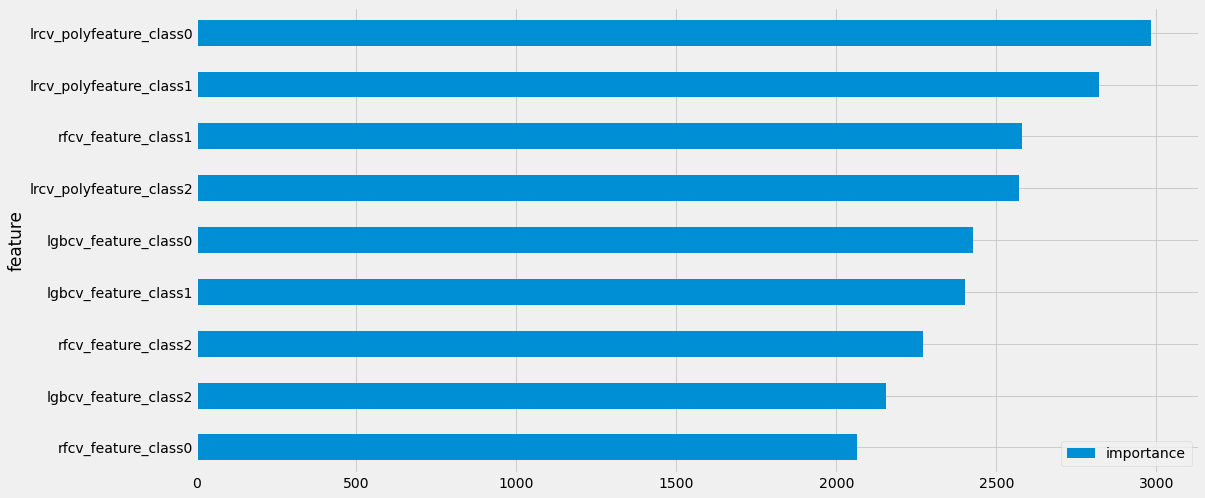

In [12]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [13]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub[target_col] = np.argmax(p_tst, axis=1)

(80000, 1)


In [14]:
sub[target_col].value_counts()

2    40731
0    29986
1     9283
Name: class, dtype: int64

In [31]:
sub.to_csv(sub_file)